
<h1 id="CIFAR10-을-CNN-으로-학습하기.-여러-학습-방법으로-비교">CIFAR10 을 CNN 으로 학습하기. 여러 학습 방법으로 비교<a class="anchor-link" href="#CIFAR10-을-CNN-으로-학습하기.-여러-학습-방법으로-비교">¶</a></h1>


In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(7) learning rate decay
#from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.002
num_epoch=10




<h1 id="1.-CIFAR10-train,-test-dataset-가져오기(163-MB)">1. CIFAR10 train, test dataset 가져오기(163 MB)<a class="anchor-link" href="#1.-CIFAR10-train,-test-dataset-가져오기(163-MB)">¶</a></h1><h3 id="MNIST:-11MB">MNIST: 11MB<a class="anchor-link" href="#MNIST:-11MB">¶</a></h3>


In [2]:

#(0)
#cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(), target_transform=None, download=True)                        
#cifar_test=dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# (2) Data augmentation
#cifar_train=dset.CIFAR10("CIFAR10/",train=True,
#                       transform=transforms.Compose([
#                            transforms.Scale(36),
#                            transforms.CenterCrop(32),
#                            transforms.RandomHorizontalFlip(),
#                            transforms.Lambda(lambda x: x.rotate(90)),
#                            transforms.ToTensor()
#                        ]))

#(4) Data Normalization
cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                         ])
                         , target_transform=None, download=True)

cifar_test=dset.CIFAR10("CIFAR10/",train=False,
                        transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                        ])
                        , target_transform=None, download=True)



87.1%


<h1 id="2.-대략적인-데이터-형태">2. 대략적인 데이터 형태<a class="anchor-link" href="#2.-대략적인-데이터-형태">¶</a></h1>


cifar_train 길이:  50000
cifar_test 길이:  10000
image data 형태:  torch.Size([3, 32, 32])
label:  9


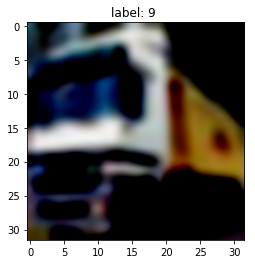

In [3]:

print ("cifar_train 길이: ", len(cifar_train))
print ("cifar_test 길이: ", len(cifar_test))

#데이터 하나 형태
image, label = cifar_train.__getitem__(1) # 1번째 데이터
print ("image data 형태: ", image.size())
print ("label: " , label)

#그리기
img = image.numpy() # image 타입을 numpy 로 변환 (3,32,32)

# (3, 32, 32) -> (32, 32, 3)
r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1],img.shape[2],img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d " %label )
plt.imshow(img2, interpolation='bicubic')
plt.show()



In [4]:

def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        with torch.no_grad():
          img = imgs.cuda()
        #img = Variable(imgs,volatile=True).cuda() # x
        #label = Variable(labels) # y
        with torch.no_grad():
          label=labels.cuda()
        #label = Variable(labels).cuda()
        # .cuda() : GPU 에 로드되기 위함, 만약 CPU로 설정되 있다면 에러남
        
        ouput = imodel.forward(img) # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))



In [5]:

# === 3. 데이터 로드함수 ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === 4.모델 선언 ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            #nn.ReLU(),
            #nn.Dropout2d(0.2),  #(1) drop out
            nn.BatchNorm2d(16), #(5) Batch normalization
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1),
            #nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            #nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8,100),
            #nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    # (3) weight initialization
    #    for m in self.modules():
    #        if isinstance(m,nn.Conv2d):
    #            init.kaiming_normal(m.weight.data) # ReLU 일 떄
    #            m.bias.data.fill_(0)
    #        if isinstance(m,nn.Linear):
    #            init.kaiming_normal(m.weight.data)
    #            m.bias.data.fill_(0)
        
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out

model=CNN().cuda()



AssertionError: Torch not compiled with CUDA enabled

In [ ]:

# === 5. loss, optimizer ===
loss_func=nn.CrossEntropyLoss()
#optimizer= torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) # (6) Adam optimizer

#scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2) # (7) learning rate decay

model.train() # train mode 로 바꾸기 -> dropout, batch nomalozation 에 영향을 줌.

# === 6. 학습 ===
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        with torch.no_grad():
          x= image.cuda()
        #x=Variable(image).cuda()
        with torch.no_grad():
          y_= label.cuda()
        #y_=Variable(label).cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)




<h1 id="1st-Try-(ReLU,-Data-Nomalization-,-Drop-out,-SGD,-BS-=-16Epoch-=-1,-LR=0.002)">1st Try (ReLU, Data Nomalization , Drop out, SGD, BS = 16Epoch = 1, LR=0.002)<a class="anchor-link" href="#1st-Try-(ReLU,-Data-Nomalization-,-Drop-out,-SGD,-BS-=-16Epoch-=-1,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="2nd-Try-(ELU,-Data-Nomalization-,-Drop-out,-SGD,-BS-=-16Epoch-=-1,-LR=0.002)">2nd Try (ELU, Data Nomalization , Drop out, SGD, BS = 16Epoch = 1, LR=0.002)<a class="anchor-link" href="#2nd-Try-(ELU,-Data-Nomalization-,-Drop-out,-SGD,-BS-=-16Epoch-=-1,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="3rd-Try-(ReLU,-Data-Nomalization-,-Drop-out,-Adam,-BS-=-16Epoch-=-1,-LR=0.002)">3rd Try (ReLU, Data Nomalization , Drop out, Adam, BS = 16Epoch = 1, LR=0.002)<a class="anchor-link" href="#3rd-Try-(ReLU,-Data-Nomalization-,-Drop-out,-Adam,-BS-=-16Epoch-=-1,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="4th-Try-(ReLU,-Batch-Nomalization,-Drop-out,-Adam,-BS-=-16,-Epoch-=-1,-LR=0.002)">4th Try (ReLU, Batch Nomalization, Drop out, Adam, BS = 16, Epoch = 1, LR=0.002)<a class="anchor-link" href="#4th-Try-(ReLU,-Batch-Nomalization,-Drop-out,-Adam,-BS-=-16,-Epoch-=-1,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="5th-Try-(ReLU,-Batch-Nomalization,-Drop-out(0.1),-Adam,-BS-=-64,-Epoch-=-5,-LR=0.002)">5th Try (ReLU, Batch Nomalization, Drop out(0.1), Adam, BS = 64, Epoch = 5, LR=0.002)<a class="anchor-link" href="#5th-Try-(ReLU,-Batch-Nomalization,-Drop-out(0.1),-Adam,-BS-=-64,-Epoch-=-5,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="6th-Try-(ReLU,-Batch-Nomalization,-Drop-out,-Adam,-BS-=-64,-Epoch-=-5,-LR=0.002)">6th Try (ReLU, Batch Nomalization, Drop out, Adam, BS = 64, Epoch = 5, LR=0.002)<a class="anchor-link" href="#6th-Try-(ReLU,-Batch-Nomalization,-Drop-out,-Adam,-BS-=-64,-Epoch-=-5,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="7th-Try-(ReLU,-Batch-Nomalization,-Drop-out,-Adam,-BS-=-64,-Epoch-=-10,-LR=0.002,-more-layer)">7th Try (ReLU, Batch Nomalization, Drop out, Adam, BS = 64, Epoch = 10, LR=0.002, more layer)<a class="anchor-link" href="#7th-Try-(ReLU,-Batch-Nomalization,-Drop-out,-Adam,-BS-=-64,-Epoch-=-10,-LR=0.002,-more-layer)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="8th-Try-(ReLU,-Data-Nomalization,-Drop-out,-Learning-rate-scheduling,-BS-=-64,-Epoch-=-40,-LR=0.002)">8th Try (ReLU, Data Nomalization, Drop out, Learning rate scheduling, BS = 64, Epoch = 40, LR=0.002)<a class="anchor-link" href="#8th-Try-(ReLU,-Data-Nomalization,-Drop-out,-Learning-rate-scheduling,-BS-=-64,-Epoch-=-40,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="9th-Try-(ReLU,-Data-Nomalization,-Drop-out,-Learning-rate-scheduling,-BS-=-16,-Epoch-=-40,-LR=0.002)">9th Try (ReLU, Data Nomalization, Drop out, Learning rate scheduling, BS = 16, Epoch = 40, LR=0.002)<a class="anchor-link" href="#9th-Try-(ReLU,-Data-Nomalization,-Drop-out,-Learning-rate-scheduling,-BS-=-16,-Epoch-=-40,-LR=0.002)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="10th-Try-(LeakyReLU,-Batch-Nomalization,-Adam,-BS-=-16,-Epoch-=-10,-LR=0.001)">10th Try (LeakyReLU, Batch Nomalization, Adam, BS = 16, Epoch = 10, LR=0.001)<a class="anchor-link" href="#10th-Try-(LeakyReLU,-Batch-Nomalization,-Adam,-BS-=-16,-Epoch-=-10,-LR=0.001)">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="(0)-Naive-Test">(0) Naive Test<a class="anchor-link" href="#(0)-Naive-Test">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="(3)-weight-initialization">(3) weight initialization<a class="anchor-link" href="#(3)-weight-initialization">¶</a></h1>


In [ ]:

model.eval() #elvaluation(test) mode 로 바꾸기 -> dropout, batch nomalization 에 영향을 줌.
ComputeAccr(test_loader, model)




<h1 id="(4)-Data-Normalization">(4) Data Normalization<a class="anchor-link" href="#(4)-Data-Normalization">¶</a></h1>


In [ ]:

ComputeAccr(test_loader,model)




<h1 id="(5)-Batch-normalization">(5) Batch normalization<a class="anchor-link" href="#(5)-Batch-normalization">¶</a></h1>


In [ ]:

ComputeAccr(test_loader,model)




<h1 id="(6)-Adam-optimizer">(6) Adam optimizer<a class="anchor-link" href="#(6)-Adam-optimizer">¶</a></h1>


In [ ]:

ComputeAccr(test_loader,model)




<h1 id="(7)-learning-rate-decay)">(7) learning rate decay)<a class="anchor-link" href="#(7)-learning-rate-decay)">¶</a></h1>


In [ ]:

ComputeAccr(test_loader,model)

